In [19]:
!nvidia-smi

Sat Feb 19 12:05:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download Dataset

In [21]:
!pip install -q kaggle
!mkdir ~/.kaggle 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [22]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
!rm -rf ~/.kaggle/kaggle.json
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle 
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d nguyentrongquocdat/object-detection-and-drivable-lane-masking

100% 5.83G/5.83G [01:51<00:00, 57.9MB/s]
100% 5.83G/5.83G [01:51<00:00, 56.1MB/s]


In [7]:
!unzip /content/object-detection-and-drivable-lane-masking.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/labels/drivable_labels/masks/val/be769e9f-ed37df2b.png  
  inflating: dataset/labels/drivable_labels/masks/val/be76ea62-78b2c8f8.png  
  inflating: dataset/labels/drivable_labels/masks/val/be776742-fe6599b2.png  
  inflating: dataset/labels/drivable_labels/masks/val/be777044-7db298a4.png  
  inflating: dataset/labels/drivable_labels/masks/val/be777044-db29e596.png  
  inflating: dataset/labels/drivable_labels/masks/val/be7783b0-b44ff154.png  
  inflating: dataset/labels/drivable_labels/masks/val/be791a81-a6b53fef.png  
  inflating: dataset/labels/drivable_labels/masks/val/be7b856e-d1ece683.png  
  inflating: dataset/labels/drivable_labels/masks/val/be7c5bf9-f31d60c1.png  
  inflating: dataset/labels/drivable_labels/masks/val/be80a253-75e6f6aa.png  
  inflating: dataset/labels/drivable_labels/masks/val/be819732-9cff62ba.png  
  inflating: dataset/labels/drivable_labels/masks/val/be832d0b-0ed20122.png  
  inflating: 

# Data Preprocessing

In [8]:
import os 
import cv2
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

### Plot data distribution

In [ ]:
def plot_attribute_distribution(annotations):
    counter = {attribution: {} for attribution in annotations[0]['attributes']}
    for anno in annotations:
        if 'attributes' not in anno:
            continue
        for attr in anno['attributes'].keys():
            infor = anno['attributes'][attr]
            if infor not in counter[attr]:
                counter[attr][infor] = 0
            counter[attr][infor] += 1

    fig, axs = plt.subplots(1, 3, figsize=(24, 3))
    for (key, value), ax in zip(counter.items(), axs):
        ax.set_title(key)
        ax.bar(value.keys(), value.values())
        ax.set_xticklabels(labels=value.keys(), rotation=30, ha='right')
    plt.show()

In [ ]:
def plot_class_distribution(annotations):
    class_counter = {}
    for anno in annotations:
        if "labels" not in anno:
            continue
        for label in anno['labels']:
            category = label['category']
            if category not in class_counter:
                class_counter[category] = 0
            class_counter[category] += 1
    plt.figure(figsize=(20, 7))
    plt.title("class")
    plt.bar(class_counter.keys(), class_counter.values())
    plt.show()

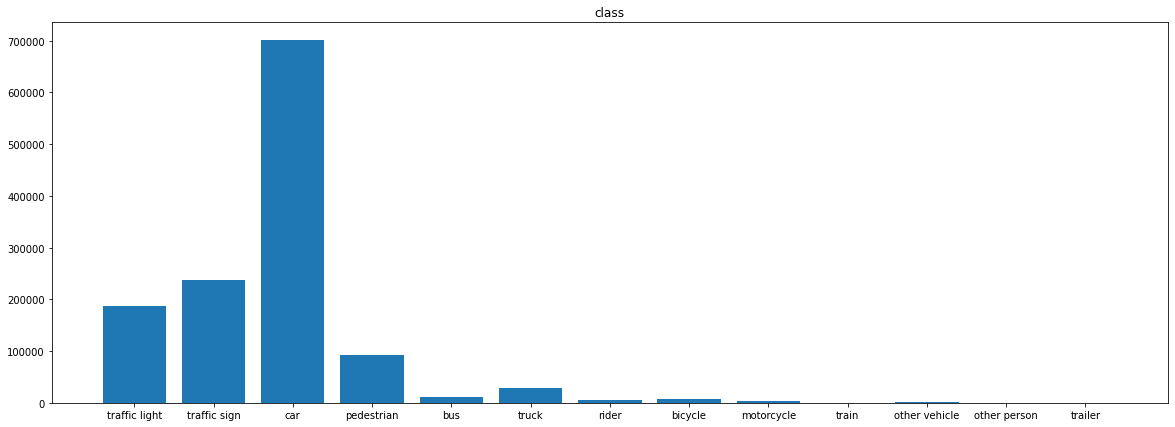

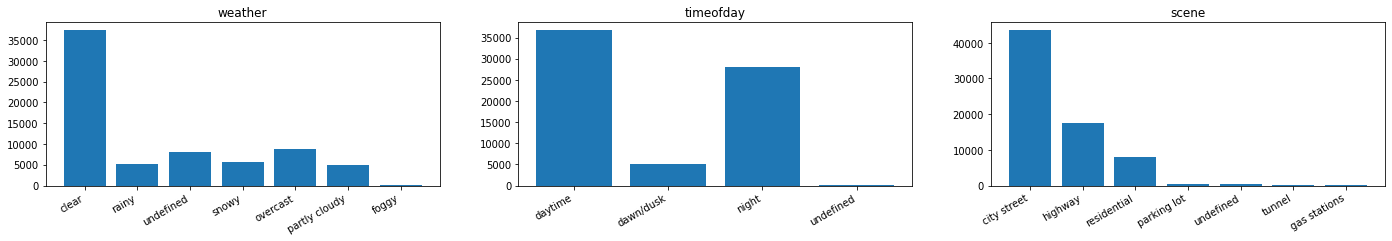

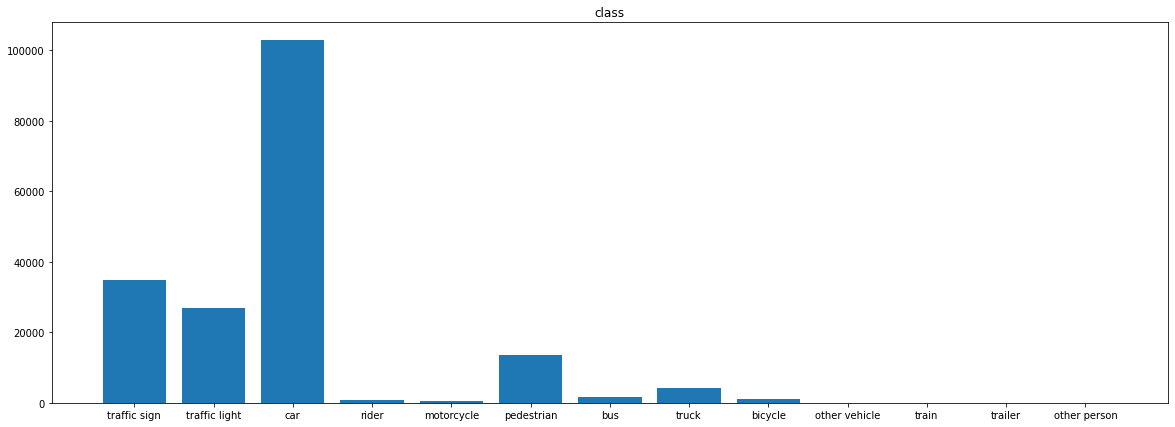

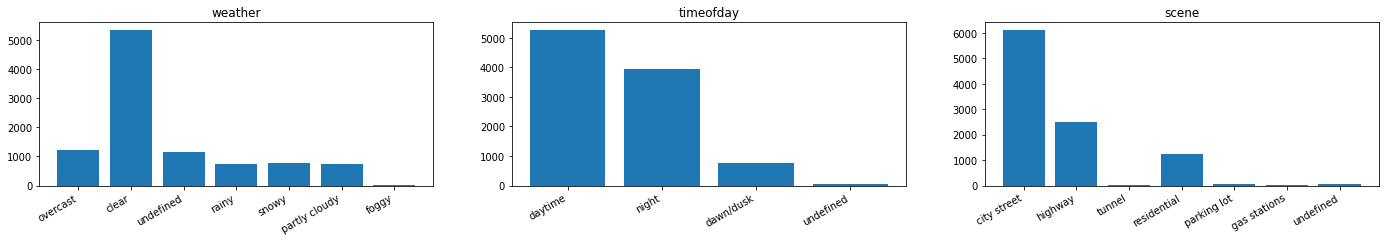

In [ ]:
DATA_ROOT = "./dataset"
for phase in ['train', 'test']:
    json_path = os.path.join(DATA_ROOT, "labels", "obj_labels", "det_{}.json".format(phase))
    f = open(json_path, "r")
    annotations = json.load(f)

    plot_class_distribution(annotations)
    plot_attribute_distribution(annotations)

### Get Image Size

In [9]:
# for phase in ['test', 'train']:
#     DATA_ROOT = "./dataset"
#     img_root = "/content/dataset/images/{}".format(phase)
    
#     img_sizes = [] 
#     for fname in os.listdir(img_root):
#         fname = os.path.join(img_root, fname)
#         img = cv2.imread(fname)
#         if img.shape not in img_sizes:
#             img_sizes.append(img.shape)

#     print(img_sizes)


FileNotFoundError: ignored

### Convert Json to Csv

In [ ]:
def get_label_map(annotations):
    categories = []
    for anno in annotations:
        if 'labels' not in anno:
            continue
        for label in anno['labels']:
            if label['category'] not in categories:
                categories.append(label['category'])

    label_map = {}
    for idx, category in enumerate(categories):
        label_map[idx] = category
    return label_map

In [ ]:
def convert_json_dataframe(json_path, img_size):
    f = open(json_path, "r")
    annotations = json.load(f)
    w, h, _ = 1280, 720, 3

    df = {'fname': [], 'x_min': [], 'y_min': [], 'x_max': [], 'y_max': [], 'category': []}
    for sample in annotations:
        if 'labels' not in sample:
            continue

        for label in sample['labels']:
            x_min, y_min = label['box2d']['x1']/w, label['box2d']['y1']/h
            x_max, y_max = label['box2d']['x2']/w, label['box2d']['y2']/h
            category = label['category']

            df['fname'].append(sample['name'])
            df['x_min'].append(x_min)
            df['y_min'].append(y_min)
            df['x_max'].append(x_max)
            df['y_max'].append(y_max)
            df['category'].append(category)

    df = pd.DataFrame(df)
    return df

In [ ]:
DATA_ROOT = "./dataset"
for phase in ['val', 'train']:
    json_path = os.path.join(DATA_ROOT, "labels", "obj_labels", "det_{}.json".format(phase))
    
    df = convert_json_dataframe(json_path)
    print(len(df))
    print(df.head())
    csv_path = os.path.join(DATA_ROOT, "labels", "obj_labels", "det_{}.csv".format(phase))
    df.to_csv(csv_path, index=False)

TypeError: ignored

### Convert JSON to TXT (Yolo)

In [10]:
def get_class_map(annotations):
    classes = ['traffic light', 'traffic sign', 'car', 'pedestrian', 'bus', 'truck', 'rider', 'bicycle', 'motorcycle', 'train', 'other vehicle', 'other person', 'trailer']
    # for sample in annotations:
    #     if 'labels' not in sample:
    #         continue
    #     for object_label in sample['labels']:
    #         if object_label['category'] not in classes:
    #             classes.append(object_label['category'])
    
    class_map = {}
    for idx, label in enumerate(classes):
        class_map[label] = idx
    return class_map, classes

In [26]:
def convert_json_txt(annotations, label_root, class_map, training=True):
    try:
        os.makedirs(label_root)
    except:
        pass
    w, h, _ = 1280, 720, 3

    count = 0
    for sample in annotations:
        if 'labels' not in sample:
            continue

        fname = '.'.join(sample['name'].split('.')[:-1]) + '.txt'
        file_path = os.path.join(label_root, fname)

        with open(file_path, 'w') as f:
            for object_label in sample['labels']:
                label = class_map[object_label['category']]
                x_min, y_min = object_label['box2d']['x1']/w, object_label['box2d']['y1']/h
                x_max, y_max = object_label['box2d']['x2']/w, object_label['box2d']['y2']/h
                x_cen, y_cen = (x_max+x_min)/2, (y_max+y_min)/2
                w_box, h_box = x_max-x_min, y_max-y_min
                if (w_box*1280)*(h_box*720) < 50 and training:
                    count += 1 
                    continue 
    # print(count)
                f.write("{} {} {} {} {}\n".format(label, x_cen, y_cen, w_box, h_box))

In [12]:
def create_yaml(data_root, classes, yaml_path):
    content = {}
    content['path'] = data_root 
    for phase in ['train', 'val', 'test']:
        img_root = os.path.join(data_root, 'images', phase)
        if os.path.exists(img_root):
            content[phase] = img_root
    
    content['nc'] = len(classes)
    content['names'] = classes

    with open(yaml_path, 'w') as f: 
        yaml.dump(content, f)

In [13]:
!rm -rf /content/dataset/labels/train
!rm -rf /content/dataset/labels/val

In [27]:
data_root = '/content/dataset'

json_path = os.path.join(data_root, 'labels', 'obj_labels', 'det_{}.json'.format('train'))
with open(json_path, 'r') as f: 
    annotations = json.load(f)
class_map, classes = get_class_map(annotations)
print(classes)
print(class_map)

for phase in ['train', 'val']:
    json_path = os.path.join(data_root, 'labels', 'obj_labels', 'det_{}.json'.format(phase))
    label_root = os.path.join(data_root, 'labels', phase)

    with open(json_path, 'r') as f: 
        annotations = json.load(f)
    convert_json_txt(annotations, label_root, class_map=class_map, training=phase == 'train')

create_yaml(data_root, classes, os.path.join(data_root, "dataset.yaml"))

['traffic light', 'traffic sign', 'car', 'pedestrian', 'bus', 'truck', 'rider', 'bicycle', 'motorcycle', 'train', 'other vehicle', 'other person', 'trailer']
{'traffic light': 0, 'traffic sign': 1, 'car': 2, 'pedestrian': 3, 'bus': 4, 'truck': 5, 'rider': 6, 'bicycle': 7, 'motorcycle': 8, 'train': 9, 'other vehicle': 10, 'other person': 11, 'trailer': 12}


# Plot Sample Image

135a9651-48e55e5c.jpg


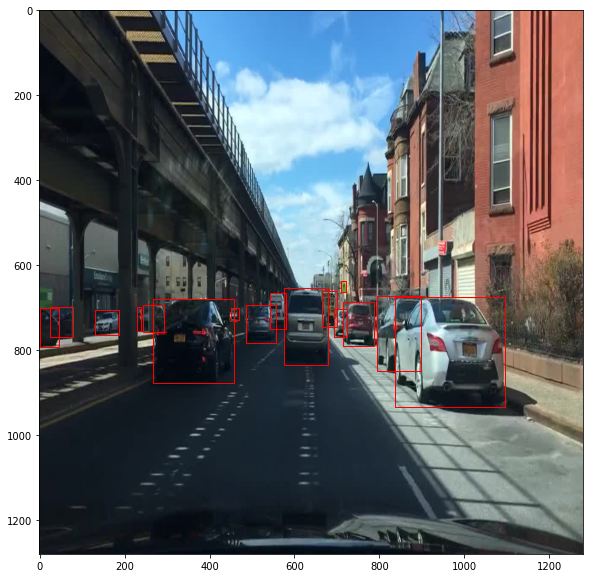

In [28]:
import random
def plot_box(img_path, boxes, img_size):
    img = Image.open(img_path)
    img = img.resize(img_size)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    for box in boxes:
        label, x_cen, y_cen, w_box, h_box = box
        x_min, y_min = x_cen-w_box/2, y_cen-h_box/2 
        rect = patches.Rectangle((x_min, y_min), w_box, h_box, linewidth=1, edgecolor='r', facecolor='none', label=label)
        ax.add_patch(rect)
    plt.show()


img_root = '/content/dataset/images/train'
label_root = '/content/dataset/labels/train'
imgs = os.listdir(img_root)
img = random.choice(imgs)

print(img)
img_name = img.split('.')[0]
img_path = os.path.join(img_root, img)
label_path = os.path.join(label_root, img_name + '.txt')

img_size = 1280, 1280
w, h = img_size
with open(label_path) as f:
    content = f.readlines()
    boxes = []
    for line in content:
        label, x_cen, y_cen, w_box, h_box = line.split()
        x_cen, y_cen = float(x_cen)*w, float(y_cen)*h
        w_box, h_box = float(w_box)*w, float(h_box)*h
        boxes.append([label, x_cen, y_cen, w_box, h_box])
plot_box(img_path, boxes, img_size)
    
            

In [29]:
print(len(os.listdir('/content/dataset/images/val')))
print(len(os.listdir('/content/dataset/labels/val')))

10000
10000


# YoloV5

In [15]:
%cd /content
!rm -rf /content/yolov5

/content


In [16]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 10912, done.
remote: Total 10912 (delta 0), reused 0 (delta 0), pack-reused 10912
Receiving objects: 100% (10912/10912), 11.01 MiB | 10.46 MiB/s, done.
Resolving deltas: 100% (7541/7541), done.
/content/yolov5
     |████████████████████████████████| 596 kB 9.9 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!python train.py --img 720 \
                 --batch 16 \
                 --epochs 100 \
                 --data /content/dataset/dataset.yaml \
                 --project /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox \
                 --weights yolov5l.pt \
                 --resume /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp/weights/last.pt

train: weights=yolov5l.pt, cfg=, data=/content/dataset/dataset.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=16, imgsz=720, rect=False, resume=/content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp/weights/last.pt, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Resuming training from /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp/weights/last.pt
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyper

## Evaluate 

In [ ]:
best_weight = '/content/best.pt'

In [30]:
!python /content/yolov5/val.py --weights /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp/weights/last.pt \
                               --data /content/dataset/dataset.yaml \
                               --img 720 \
                               --batch-size 1 
                            #    --project {val_saving_dir}
                            # --conf-thres \ # default=0.001 
                            # --iou-thres \ # default=0.6
                            # --task \ # ['train', 'val', 'test'] default='val'

val: data=/content/dataset/dataset.yaml, weights=['/content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp/weights/last.pt'], batch_size=1, imgsz=720, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-270-g0365379 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 367 layers, 46172898 parameters, 0 gradients, 108.0 GFLOPs
val: Scanning '/content/dataset/labels/val' images and labels...10000 found, 0 missing, 0 empty, 0 corrupt: 100% 10000/10000 [00:04<00:00, 2077.83it/s]
val: New cache created: /content/dataset/labels/val.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 10000/10000 [08:47<00:00, 18.94it/s]
                 all      10000     186033       0.76      0.412

# New Version

In [ ]:
import os 
import shutil
import numpy as np 
import pandas as pd
import yaml
import copy 
from PIL import Image  
import matplotlib.pyplot as plt
from typing import Dict

In [ ]:
def area(row, img_size):
    width = (row['x_max'] - row['x_min']) * img_size[0]
    height = (row['y_max'] - row['y_min']) * img_size[1] 
    return width*height

dfs = {}
img_size = (1280, 720)
for phase in ['train', 'val']:
    df = pd.read_csv(f'/content/dataset/labels/obj_labels/det_{phase}.csv')
    if phase == 'train':
        drop_idx = []
        for idx, row in df.iterrows(): 
            if area(row, img_size) < 50:
                drop_idx.append(idx)
        df.drop(index=drop_idx, inplace=True)
        print(len(drop_idx))

    img_root = f'/content/dataset/images/{phase}'
    df['fname'] = df['fname'].apply(lambda fname: os.path.join(img_root, fname))
    df.set_index('fname', inplace=True)
    print(df.head())
    dfs[phase] = df 

12171
                                                       x_min  ...       category
fname                                                         ...               
/content/dataset/images/train/0000f77c-6257be58...  0.879611  ...  traffic light
/content/dataset/images/train/0000f77c-6257be58...  0.903890  ...  traffic light
/content/dataset/images/train/0000f77c-6257be58...  0.863804  ...   traffic sign
/content/dataset/images/train/0000f77c-6257be58...  0.000000  ...   traffic sign
/content/dataset/images/train/0000f77c-6257be58...  0.038629  ...            car

[5 rows x 5 columns]
                                                      x_min  ...       category
fname                                                        ...               
/content/dataset/images/val/b1c66a42-6f7d68ca.jpg  0.781796  ...   traffic sign
/content/dataset/images/val/b1c66a42-6f7d68ca.jpg  0.167667  ...   traffic sign
/content/dataset/images/val/b1c66a42-6f7d68ca.jpg  0.622902  ...   traffic sign
/cont

# Data Processing

## Convert CSV to Yolo Dataset 


Function `csv_to_yolo_data_structure(dfs: Dict[str, pd.DataFrame], save_memory=True, update_label=False)`.

**Purpose**: Create new directory name `yolo_dataset` has the structure of yolov5, that contain images and label of your dataset.

**Parameters**:

* `classes`: List of classes which will become label map

* `save_memory`: If it is `True`, it will move the original images to new directory, otherwise it just copy the original images

* `update_label`: If it is `True`, it just update label file `*.txt` and don't touch to images (it assume that images are already in directory)

* `dfs` Is a dict of dataframes:
    * `dfs['train'] = df_train`
    * `dfs['val'] = df_val`
    * `dfs['test'] = df_test` (Optinal)



Each dataframe need 5 columns 
* `index`: Is the full path of image 
* `x_min, y_min, x_max, y_max`: Are the coordinates of 1 box in images 
* `category`: Is the category of box 

**Note**: If one image has multi boxes, each box will be one row of dataframe and it has the same index.

### Define function 

In [ ]:
def create_yaml_file(dfs, phases, classes=None):
    yaml_content = {'path': os.getcwd() + os.sep + 'yolo_dataset'} 

    # get classes 
    yaml_content['names'] = []
    for phase in phases:
        yaml_content[phase] = os.path.join(os.getcwd(), 'yolo_dataset', 'images', phase)
        if classes is None:
            yaml_content['names'].extend(dfs[phase]['category'].unique())

    if classes is None:
        yaml_content['names'] = np.sort(np.unique(yaml_content['names'])).tolist()
    else:
        yaml_content['names'] = classes

    # save yaml file 
    yaml_content['nc'] = len(yaml_content['names'])
    yaml_path = os.getcwd() + os.sep + 'yolo_dataset' + os.sep + 'dataset.yaml'
    with open(yaml_path, 'w') as f: 
        yaml.dump(yaml_content, f)

    return yaml_content


def csv_to_yolo_data_structure(dfs: Dict[str, pd.DataFrame], classes=None, save_memory=False, update_label=False):
    phases = [phase for phase in ['train', 'test', 'val'] if phase in dfs]

    # Create new directory for yolo dataset 
    os.makedirs(os.getcwd() + os.sep + 'yolo_dataset' + os.sep + 'images', exist_ok=True)
    os.makedirs(os.getcwd() + os.sep + 'yolo_dataset' + os.sep + 'labels', exist_ok=True)

    # Create yaml file
    yaml_content = create_yaml_file(dfs, phases, classes)

    label_map = {label: idx for idx, label in enumerate(yaml_content['names'])}

    for phase in phases:
        num_images = 0 
        num_objects = 0

        # Create images root and labels root 
        img_root = os.path.join(os.getcwd(), 'yolo_dataset', 'images', phase)
        os.makedirs(img_root, exist_ok=True)
        label_root = os.path.join(os.getcwd(), 'yolo_dataset', 'labels', phase)
        os.makedirs(label_root, exist_ok=True)

        dfs[phase] = dfs[phase].groupby(by='fname').agg(list)
        for img_path, boxes in dfs[phase].iterrows():
            fname = os.path.basename(img_path)
            img_name = '.'.join(fname.split('.')[:-1])
            label_file = label_root + os.sep + img_name + '.txt'

            # create label file 
            boxes = zip(boxes['x_min'], boxes['y_min'], boxes['x_max'], boxes['y_max'], boxes['category'])
            with open(label_file, 'w') as f:
                for x_min, y_min, x_max, y_max, category in boxes:
                    x_cen, y_cen = (x_min + x_max) / 2, (y_min + y_max) / 2
                    w_box, h_box = (x_max - x_min), (y_max - y_min)
                    label = label_map[category] 
                    f.write(f'{label} {x_cen} {y_cen} {w_box} {h_box}\n')
                    num_objects += 1

            # create image 
            if not update_label:
                if save_memory:
                    # move image to yolo dataset 
                    shutil.move(img_path, img_root + os.sep + fname)
                else:
                    # copy image to yolo dataset
                    shutil.copyfile(img_path, img_root + os.sep + fname)
                num_images += 1
        
        print(f'Phase {phase} has {num_images} new images and {num_objects} new objects')

### Excute function

In [ ]:
# !rm -rf /content/yolo_dataset

In [ ]:
classes = ['traffic light', 'traffic sign', 'car', 'pedestrian', 'bus', 'truck', 'rider', 'bicycle', 'motorcycle', 'train', 'other vehicle', 'other person', 'trailer']
csv_to_yolo_data_structure(copy.deepcopy(dfs), classes=None, save_memory=True, update_label=False)

Phase train has 69850 new images and 1262621 new objects
Phase val has 10000 new images and 186033 new objects


# YoloV5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  
!pip install -r ./yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 10740, done.
remote: Total 10740 (delta 0), reused 0 (delta 0), pack-reused 10740
Receiving objects: 100% (10740/10740), 10.83 MiB | 32.51 MiB/s, done.
Resolving deltas: 100% (7427/7427), done.
     |████████████████████████████████| 596 kB 7.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install -q wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 8.8 MB/s 
     |████████████████████████████████| 97 kB 9.3 MB/s 
     |████████████████████████████████| 143 kB 92.5 MB/s 
     |████████████████████████████████| 180 kB 75.8 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Prepare parameters

### New Training Process and Evaluation

In [ ]:
img_size = 720
batch_size = 16
# WARNING: If you don't know how many epoch you need to train just define as big as you can
# Because when it start training LR Schedule will base on epoch to setup schedule
# that you can't not redefine epoch when it start training 
epochs = 100
data_yaml = '/content/yolo_dataset/dataset.yaml'

model_type = 'yolov5l.pt'

saving_dir = '/content/yolov5/runs' 
os.makedirs(saving_dir, exist_ok=True)
train_saving_dir = os.path.join(saving_dir, 'train')
val_saving_dir = os.path.join(saving_dir, 'val')

#### Change Hyperparameter 

There are 2 ways to change hyperparameters:
* Change the default hyperparameters in default file `yolov5/data/hyps/hyp.scratch.yaml`
* Create new yaml file (code below)

In [ ]:
hyper_parameters = {    
    'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
    'lrf': 0.2,  # final OneCycleLR learning rate (lr0 * lrf)
    'momentum': 0.937,  # SGD momentum/Adam beta1
    'weight_decay': 0.0005,  # optimizer weight decay 5e-4
    'warmup_epochs': 3.0,  # warmup epochs (fractions ok)
    'warmup_momentum': 0.8,  # warmup initial momentum
    'warmup_bias_lr': 0.1,  # warmup initial bias lr
    'box': 0.05,  # box loss gain
    'cls': 0.5,  # cls loss gain
    'cls_pw': 1.0,  # cls BCELoss positive_weight
    'obj': 1.0,  # obj loss gain (scale with pixels)
    'obj_pw': 1.0,  # obj BCELoss positive_weight
    'iou_t': 0.20,  # IoU training threshold
    'anchor_t': 4.0,  # anchor-multiple threshold
    # anchors: 3,  # anchors per output layer (0 to ignore)
    'fl_gamma': 0.0,  # focal loss gamma (efficientDet default gamma=1.5)
    'hsv_h': 0.015,  # image HSV-Hue augmentation (fraction)
    'hsv_s': 0.7,  # image HSV-Saturation augmentation (fraction)
    'hsv_v': 0.4,  # image HSV-Value augmentation (fraction)
    'degrees': 0.0,  # image rotation (+/- deg)
    'translate': 0.1,  # image translation (+/- fraction)
    'scale': 0.5,  # image scale (+/- gain)
    'shear': 0.0,  # image shear (+/- deg)
    'perspective': 0.0,  # image perspective (+/- fraction), range 0-0.001
    'flipud': 0.0,  # image flip up-down (probability)
    'fliplr': 0.5, # image flip left-right (probability)
    'mosaic': 1.0,  # image mosaic (probability)
    'mixup': 0.0,  # image mixup (probability)
    'copy_paste': 0.0, # segment copy-paste (probability)
}

In [ ]:
# Create neew hyperparameters yaml file 
hyp_yaml = os.path.join(saving_dir, 'hyp.yaml')
with open(hyp_yaml, 'w') as yaml_file:
    yaml.dump(hyper_parameters, yaml_file)

### Resume Training

In [ ]:
!rm -rf /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_tmp
!cp -r /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_tmp

In [ ]:
data_yaml = '/content/yolo_dataset/dataset.yaml'
last_model_dir = '/content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp'
last_weight = os.path.join(last_model_dir, 'weights', 'last.pt')

## Train

In [ ]:
!python /content/yolov5/train.py --img {img_size} \
                                 --batch {batch_size} \
                                 --epochs {epoch} \
                                 --data {data_yaml} \
                                 --weights {model_type} \
                                 --project {train_saving_dir} \
                                #  --hyp {hyp_yaml} \
                                #  --optimizer \ # [SGD, Adam, AdamW]
                                #  --freeze # num first layer

## Resume Training

To resume training with other paramerters you need to change the `opt.yaml` in `exp` directory. And then pass the last weights in `exp/weights/last.pt` to `--resume`

In [ ]:
opt_yaml = os.path.join(last_model_dir, 'opt.yaml')
with open(opt_yaml, 'r') as stream:
    opt = yaml.safe_load(stream)
    opt['weight'] = os.path.join(last_model_dir, 'weights', 'last.pt') 
    opt['data'] = data_yaml
    opt['hyp'] = os.path.join(last_model_dir, 'hyp.yaml') 
    opt['project'] = os.path.dirname(last_model_dir)
    opt['save_dir'] = last_model_dir

with open(opt_yaml, 'w') as stream:
    yaml.dump(opt, stream)

In [ ]:
!python /content/yolov5/train.py --resume {last_weight}

wandb: Currently logged in as: datn2107 (use `wandb login --relogin` to force relogin)
train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/data/coco128.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=/content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp/weights/last.pt, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Resuming training from /content/drive/MyDrive/Project/Autonomous_Vehicle/yolov5/yolov5l_bigbox/exp/weights/last.pt
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA

## Evaluate 

In [ ]:
best_weight = '/content/best.pt'

In [ ]:
!python /content/yolov5/val.py --weights {best_weight} \
                               --data {data_yaml} \
                               --img {img_size} \
                               --batch-size {batch_size} \
                               --project {val_saving_dir}
                            # --conf-thres \ # default=0.001 
                            # --iou-thres \ # default=0.6
                            # --task \ # ['train', 'val', 'test'] default='val'

## Export Model

You can export to (`--include`):
* **TorchScript**: `torchscript`
* **TensorFlow SavedModel**: `saved_model`
* ... see more [here](https://github.com/ultralytics/yolov5/issues/251#issue-648548660) 

In [ ]:
best_weight = '/content/best.pt'

In [ ]:
!python /content/yolov5/export.py --weights {best_weight} \
                                  --include torchscript